In [1]:
# Setting the environment variables

In [1]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

In [2]:
# Flag to force only 10% data to be selected from the dataset
# This was used only during the initial development of the code
# DONOT set this to True and finalize any inference 
use_small_sample = False
load_from_existing_features_dataset = True
save_features_dataset=False

# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number. You can refer to notebook 1 for the steps involved here.

In [3]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

# initialising the session with 14 GB driver memory
MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("log_reg") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

spark

In [4]:

print('spark.driver.memory =', spark.sparkContext.getConf().get('spark.driver.memory'))


spark.driver.memory = 14G


In [5]:
# Loading the clean data

if use_small_sample == True:
    df= spark.read.parquet("cleaned_df.parquet")
    df = df.randomSplit([.05, .95], seed=12)[0]
else:
    df= spark.read.parquet("cleaned_df.parquet")

In [6]:
df.count()

898441

In [8]:
df.show(5)

+-----------+----------+-------+---------+--------------+-----------+----------+---------+-------------+--------------+------------------+---------------------+-----------------+----+---------+------------+
|  cat_0_cln|product_id|  price|  user_id|category_level|day_of_week| cat_1_cln|brand_cln|session_count|activity_count|product_view_count|second_cat_view_count|        avg_price|hour|hour_bins|is_purchased|
+-----------+----------+-------+---------+--------------+-----------+----------+---------+-------------+--------------+------------------+---------------------+-----------------+----+---------+------------+
|electronics|   1004873| 380.28|463643038|             2|          1|smartphone|  samsung|            2|             1|                 1|                    1|493.3872257223995|  16|      2.0|           0|
|electronics|   1004767| 246.52|480835273|             2|          6|smartphone|  samsung|            5|             1|                 3|                    3|493.38722572

In [9]:
df.groupBy('is_purchased').count().show()

+------------+------+
|is_purchased| count|
+------------+------+
|           1|545347|
|           0|353094|
+------------+------+



In [7]:
from pyspark.sql import functions as F
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<hr>

## Task 3: Model Selection
3 models for classification:	
- Logistic Regression
- Decision Tree
- Random Forest

### Model 1: Logistic Regression

In [12]:
df.dtypes

[('cat_0_cln', 'string'),
 ('product_id', 'string'),
 ('price', 'float'),
 ('user_id', 'string'),
 ('category_level', 'int'),
 ('day_of_week', 'int'),
 ('cat_1_cln', 'string'),
 ('brand_cln', 'string'),
 ('session_count', 'bigint'),
 ('activity_count', 'bigint'),
 ('product_view_count', 'bigint'),
 ('second_cat_view_count', 'bigint'),
 ('avg_price', 'double'),
 ('hour', 'int'),
 ('hour_bins', 'double'),
 ('is_purchased', 'int')]

In [9]:
numeric_cols = ['price', 'session_count', 'activity_count',
                'product_view_count', 'second_cat_view_count',
                'avg_price'
               ]

# List of categorical string columns
categorical_str_cols = ['cat_0_cln', 'cat_1_cln', 'brand_cln']

# list of categorical numeric columns
categorical_num_cols = ['category_level', 'day_of_week', 'hour', 'hour_bins']

In [14]:
cols = numeric_cols + categorical_num_cols
# Additional steps for Logistic regression - Feature selection, Correlation, etc.
heatmap = np.zeros((len(cols), len(cols)), dtype=float)
for i, col_i in enumerate(cols):
    for j, col_j in enumerate(cols):
        heatmap[i, j] = df.corr(col_i, col_j)

heatmap_df = pd.DataFrame(data=heatmap, index=cols, columns=cols)
heatmap_df

,price,session_count,activity_count,product_view_count,second_cat_view_count,avg_price,category_level,day_of_week,hour,hour_bins
price,1.000000,-0.057051,-0.021417,0.047003,0.033736,0.300513,0.081688,0.002161,0.033512,0.033664
session_count,-0.057051,1.000000,0.487767,0.127373,0.266267,-0.084637,0.010645,0.001337,0.061439,0.057155
activity_count,-0.021417,0.487767,1.000000,0.097497,0.068533,0.033637,0.008600,0.004751,-0.004884,-0.003371
product_view_count,0.047003,0.127373,0.097497,1.000000,0.520714,0.020543,0.008004,0.000256,-0.012385,-0.010035
second_cat_view_count,0.033736,0.266267,0.068533,0.520714,1.000000,-0.017975,-0.048058,0.000051,0.006949,0.007295
avg_price,0.300513,-0.084637,0.033637,0.020543,-0.017975,1.000000,0.309274,0.004509,0.009728,0.011438
category_level,0.081688,0.010645,0.008600,0.008004,-0.048058,0.309274,1.000000,0.000327,0.000236,0.001581
day_of_week,0.002161,0.001337,0.004751,0.000256,0.000051,0.004509,0.000327,1.000000,0.000543,0.001284
hour,0.033512,0.061439,-0.004884,-0.012385,0.006949,0.009728,0.000236,0.000543,1.000000,0.943733
hour_bins,0.033664,0.057155,-0.003371,-0.010035,0.007295,0.011438,0.001581,0.001284,0.943733,1.000000


<AxesSubplot:>

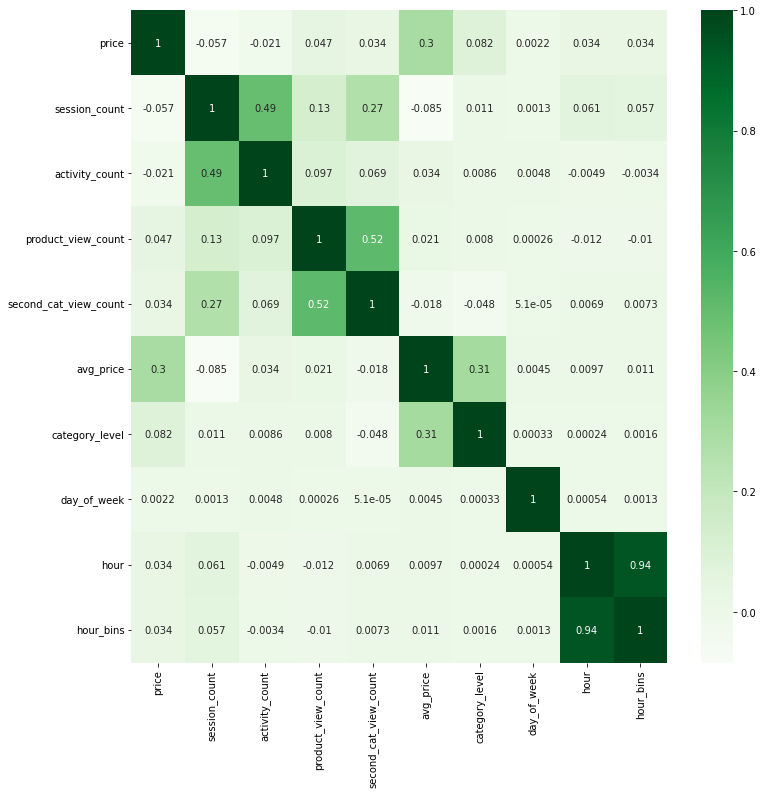

In [15]:
plt.figure(figsize=(12,12))
sns.heatmap(heatmap_df, annot=True, cmap='Greens')

In [10]:

# Listing number of distinct values in categorical columns

for col in categorical_str_cols + categorical_num_cols:
    print(f'Number of different values in {col} = {df.agg(F.countDistinct(col)).collect()[0]}')


Number of different values in cat_0_cln = Row(count(DISTINCT cat_0_cln)=14)
Number of different values in cat_1_cln = Row(count(DISTINCT cat_1_cln)=40)
Number of different values in brand_cln = Row(count(DISTINCT brand_cln)=20)
Number of different values in category_level = Row(count(DISTINCT category_level)=4)
Number of different values in day_of_week = Row(count(DISTINCT day_of_week)=7)
Number of different values in hour = Row(count(DISTINCT hour)=24)
Number of different values in hour_bins = Row(count(DISTINCT hour_bins)=4)


In [17]:
#
stages = []
# Creating a pipeline for Feature Transformations
# Starting with the categorical string cols
for col in categorical_str_cols:
    # Encode the strings in the col with an index
    indexer = StringIndexer(inputCol=col,
                            outputCol = col + '_ix',
                           )
    # OHE the indices in the col
    stages +=[indexer]
    


In [18]:
# Vector assembler to combine all the features
# Add a Vector Assembler to the pipeline stages
vector_input_cols = [c + '_ix' for c in categorical_str_cols] + \
                    categorical_num_cols

vector = VectorAssembler(inputCols = vector_input_cols,
                         outputCol = 'cat_features'
                        )
stages.append(vector)

print('stages = ')
stages

stages = 


[StringIndexer_e949fc70849b,
 StringIndexer_0c53753f0741,
 StringIndexer_1386e45a1f61,
 VectorAssembler_5fc26c30b71b]

In [19]:
print('total number of categorical columns in the dataset = ', len(vector_input_cols))

total number of categorical columns in the dataset =  7


In [20]:
# Creating a temporary df with categorical feature vector 
temp_pipeline = Pipeline(stages=stages)
cat_transformed_df = temp_pipeline.fit(df).transform(df)



In [21]:
# Selecting the top 
# selector = ChiSqSelector(numTopFeatures=1, featuresCol="features",
#                          outputCol="selectedFeatures", labelCol="is_purchased")

selector = ChiSqSelector(numTopFeatures=7,
                         featuresCol='cat_features', 
                         fpr=0.05,
                         outputCol="selectedFeatures",
                         labelCol= "is_purchased"
                        )

chi_sq_model = selector.fit(cat_transformed_df)





In [22]:
print('order of importance of features = ')
np.array(vector_input_cols)[chi_sq_model.selectedFeatures]


order of importance of features = 


array(['cat_0_cln_ix', 'cat_1_cln_ix', 'brand_cln_ix', 'category_level',
       'day_of_week', 'hour', 'hour_bins'], dtype='<U14')

In [11]:
# Since hour and hour_bins are highly correlated, 
# Also since hour_bins and hour was the least important feature, we can drop that as well

categorical_num_cols.remove('hour')
categorical_num_cols

['category_level', 'day_of_week', 'hour_bins']

#### Feature Transformation

In [12]:
# Feature transformation for categorical features
#
stages = []
# Creating a pipeline for Feature Transformations
# Starting with the categorical string cols
for col in categorical_str_cols:
    # Encode the strings in the col with an index
    indexer = StringIndexer(inputCol=col,
                            outputCol = col + '_ix',
                           )
    # OHE the indices in the col
    encoder = OneHotEncoder(inputCol=indexer.getOutputCol(),
                            outputCol=col + '_enc'
                           )
    stages +=[indexer, encoder]
    

# Processing thhe Categorical numeric cols
for col in categorical_num_cols:
    encoder = OneHotEncoder(inputCol=col,
                            outputCol=col + '_enc'
                           )
    stages += [encoder]
    
# Vector assembler to combine all the features
# Add a Vector Assembler to the pipeline stages
vector_input_cols = [c + '_enc' for c in categorical_str_cols] + \
                    [c + '_enc' for c in categorical_num_cols] + \
                    numeric_cols
print('number of features to be given to the moddel = ', len(vector_input_cols))

vector = VectorAssembler(inputCols = vector_input_cols,
                         outputCol = 'features'
                        )
stages.append(vector)

print('stages = ')
stages

number of features to be given to the moddel =  12
stages = 


[StringIndexer_39d3d8138bed,
 OneHotEncoder_28ce3beb1af7,
 StringIndexer_a61edbfba1ce,
 OneHotEncoder_30fcbbfd1358,
 StringIndexer_782af24a7fc3,
 OneHotEncoder_6104bade4eba,
 OneHotEncoder_f529db65a95c,
 OneHotEncoder_23e2558e1614,
 OneHotEncoder_8f91ecdb56a2,
 VectorAssembler_79e76ebf349d]

In [16]:
vector_input_cols

['cat_0_cln_enc',
 'cat_1_cln_enc',
 'brand_cln_enc',
 'category_level_enc',
 'day_of_week_enc',
 'hour_bins_enc',
 'price',
 'session_count',
 'activity_count',
 'product_view_count',
 'second_cat_view_count',
 'avg_price']

In [17]:
# Pipeline for the tasks
pipeline = Pipeline(stages=stages)

In [18]:
# Transforming the dataframe df
if load_from_existing_features_dataset == True:
    transformed_df = spark.read.parquet('features_df.parquet')
else:
    pipeline_model = pipeline.fit(df)
    transformed_df = pipeline_model.transform(df)

In [19]:
df.unpersist()

DataFrame[cat_0_cln: string, product_id: string, price: float, user_id: string, category_level: int, day_of_week: int, cat_1_cln: string, brand_cln: string, session_count: bigint, activity_count: bigint, product_view_count: bigint, second_cat_view_count: bigint, avg_price: double, hour: int, hour_bins: double, is_purchased: int]

In [24]:
if load_from_existing_features_dataset == False:
    pipeline_model.save('pipeline_model')

In [26]:
# Schema of the transformed df
transformed_df.printSchema()

root
 |-- cat_0_cln: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: string (nullable = true)
 |-- category_level: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- cat_1_cln: string (nullable = true)
 |-- brand_cln: string (nullable = true)
 |-- session_count: long (nullable = true)
 |-- activity_count: long (nullable = true)
 |-- product_view_count: long (nullable = true)
 |-- second_cat_view_count: long (nullable = true)
 |-- avg_price: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- hour_bins: double (nullable = true)
 |-- is_purchased: integer (nullable = true)
 |-- cat_0_cln_ix: double (nullable = false)
 |-- cat_0_cln_enc: vector (nullable = true)
 |-- cat_1_cln_ix: double (nullable = false)
 |-- cat_1_cln_enc: vector (nullable = true)
 |-- brand_cln_ix: double (nullable = false)
 |-- brand_cln_enc: vector (nullable = true)
 |-- category_level_enc: vector (nullable = 

In [27]:
# Printing the columns list that are apart from the features

set(transformed_df.columns) - set(vector_input_cols) - set(categorical_num_cols)\
        -set(categorical_str_cols) - set(numeric_cols)

{'brand_cln_ix',
 'cat_0_cln_ix',
 'cat_1_cln_ix',
 'features',
 'hour',
 'is_purchased',
 'product_id',
 'user_id'}

In [28]:
# Check if only the required columns are present to build the model
# If not, drop the redundant columns
transformed_df = transformed_df.drop('user_id', 'product_id', 'hour')

In [29]:
# Categorising the attributes into its type - Continuous and Categorical


In [30]:
# Checking the elements of the transformed df - Top 20 rows
transformed_df.show(20)

+-----------+-------+--------------+-----------+----------+---------+-------------+--------------+------------------+---------------------+-----------------+---------+------------+------------+--------------+------------+--------------+------------+---------------+------------------+---------------+-------------+--------------------+
|  cat_0_cln|  price|category_level|day_of_week| cat_1_cln|brand_cln|session_count|activity_count|product_view_count|second_cat_view_count|        avg_price|hour_bins|is_purchased|cat_0_cln_ix| cat_0_cln_enc|cat_1_cln_ix| cat_1_cln_enc|brand_cln_ix|  brand_cln_enc|category_level_enc|day_of_week_enc|hour_bins_enc|            features|
+-----------+-------+--------------+-----------+----------+---------+-------------+--------------+------------------+---------------------+-----------------+---------+------------+------------+--------------+------------+--------------+------------+---------------+------------------+---------------+-------------+--------------

In [31]:
if save_features_dataset == True:
    transformed_df.coalesce(1).write.option("header", "true").parquet("features_df.parquet")

#### Train-test split

In [32]:
transformed_df.count()

898441

In [33]:
# Since there are close to 900k rows, we can do a 80-20 split of data
# Splitting the data into train and test (Remember you are expected to compare the model later)
train, test = transformed_df.randomSplit([0.8, 0.2], seed=12)

In [34]:
train

DataFrame[cat_0_cln: string, price: float, category_level: int, day_of_week: int, cat_1_cln: string, brand_cln: string, session_count: bigint, activity_count: bigint, product_view_count: bigint, second_cat_view_count: bigint, avg_price: double, hour_bins: double, is_purchased: int, cat_0_cln_ix: double, cat_0_cln_enc: vector, cat_1_cln_ix: double, cat_1_cln_enc: vector, brand_cln_ix: double, brand_cln_enc: vector, category_level_enc: vector, day_of_week_enc: vector, hour_bins_enc: vector, features: vector]

In [35]:
# Number of rows in train and test data
print('train data length =', train.count())
print('test data length =', test.count())

train data length = 718925
test data length = 179516


#### Model Fitting

In [36]:
# Building the model
lr = LogisticRegression(featuresCol = 'features', labelCol='is_purchased', threshold=0.5)

In [37]:
# Fitting the model on transformed df
model= lr.fit(train)

#### Model Analysis

Required Steps:
- Fit on test data
- Performance analysis
    - Appropriate Metric with reasoning
    - Threshold selection

In [38]:
train_eval = model.evaluate(train)
test_eval = model.evaluate(test)

print('Train Data Recall =', train_eval.recallByLabel[1])
print('Training Precision =', train_eval.precisionByLabel[1])
print('Train Data AUC = ', train_eval.areaUnderROC)



print('Testing Data Recall =', test_eval.recallByLabel[1])
print('Testing Precision =', test_eval.precisionByLabel[1])
print('Testing Data AUC = ', test_eval.areaUnderROC)



Train Data Recall = 0.8735364285763395
Training Precision = 0.6489339786948964
Train Data AUC =  0.6551039986882875
Testing Data Recall = 0.873045871559633
Testing Precision = 0.6485782830348137
Testing Data AUC =  0.6522225289751405


In [39]:
train_recall = train_eval.recallByLabel[1]
train_precision= train_eval.precisionByLabel[1]

train_f1 = 2 * (train_recall * train_precision)/(train_recall + train_precision)

test_recall = test_eval.recallByLabel[1]
test_precision= test_eval.precisionByLabel[1]
test_f1 = 2 * (test_recall * test_precision)/(test_recall + test_precision)


print('F1 Score =', train_f1)
print('F1 Score =', test_f1)

F1 Score = 0.7446679652013544
F1 Score = 0.7442555254884171


In [40]:
def get_confusion_matrix(model_result, target='is_purchased'):

    preds = model_result.predictions.select(target, 'prediction')
    TP = preds.filter(target + '==1 and prediction==1').count()
    TN = preds.filter(target +'==0 and prediction==0').count()
    FP = preds.filter(target + '==0 and prediction==1').count()
    FN = preds.filter(target + '==1 and prediction==0').count()
    
    data = np.array([[TP, FN],
                    [FP, TN]])
    conf_matrix = pd.DataFrame(data=data,
                 index = ['True', 'False'],
                 columns = ['True', 'False']
                )
    return conf_matrix

In [41]:
print('Confusion Matrix on Training Data:')
get_confusion_matrix(train_eval)



Confusion Matrix on Training Data:


,True,False
True,381165,55182
False,206206,76372


In [42]:
print('Confusion Matrix on Testing Data:')
get_confusion_matrix(test_eval)



Confusion Matrix on Testing Data:


,True,False
True,95162,13838
False,51562,18954


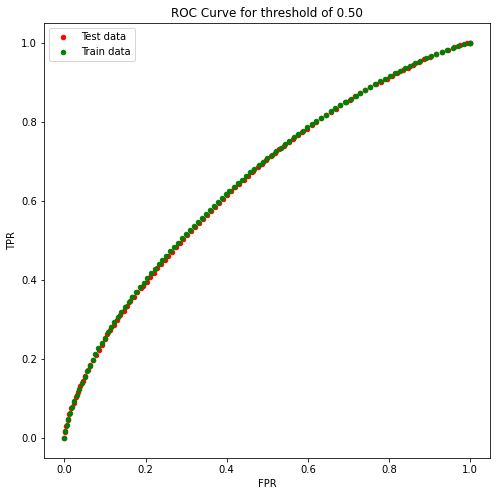

In [43]:
threshold = 0.5
test_roc = test_eval.roc.toPandas()
train_roc = train_eval.roc.toPandas()

fig, ax = plt.subplots(1,1, figsize=(8,8))
test_roc.plot( x='FPR', y='TPR', kind='scatter', label='Test data', ax=ax, c= 'r')
train_roc.plot( x='FPR', y='TPR', kind='scatter', label='Train data', ax=ax, c= 'g')
plt.legend()
plt.title('ROC Curve for threshold of {:.2f}'.format(threshold))
plt.show()


In [44]:
# Extracting only the actual target and the predicted probabilities
preds_df = test_eval.predictions.select('is_purchased', 'probability')
preds_df.show(truncate=False)

+------------+----------------------------------------+
|is_purchased|probability                             |
+------------+----------------------------------------+
|1           |[0.45617081577204044,0.5438291842279596]|
|0           |[0.5138630052562019,0.486136994743798]  |
|1           |[0.45730215990225326,0.5426978400977467]|
|0           |[0.7684189312948596,0.23158106870514036]|
|0           |[0.2337277003452132,0.7662722996547868] |
|0           |[0.5257561812730257,0.47424381872697424]|
|1           |[0.5143387579698131,0.48566124203018685]|
|0           |[0.5817537447844457,0.41824625521555425]|
|0           |[0.4419973857787794,0.5580026142212205] |
|1           |[0.38011751927160703,0.6198824807283929]|
|0           |[0.5656581337654201,0.43434186623458]   |
|1           |[0.4817968562883076,0.5182031437116924] |
|1           |[0.43866939125380916,0.5613306087461909]|
|0           |[0.40332300100867136,0.5966769989913285]|
|0           |[0.402694787863249,0.5973052121367

In [45]:
from pyspark.sql.functions import udf, when
from pyspark.sql.types import FloatType

### Precision-Recall Curve

In [46]:
# Define a udf to extract the probability of getting target=1 from the model predicted probabilities
probability_extraction=udf(lambda x:float(x[1]),FloatType())


threshold_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
result=[]

for threshold in threshold_list:
    new_pred = preds_df.withColumn('new_prediction', 
                              when(probability_extraction(
                                  preds_df['probability']) > threshold, 1).otherwise(0))
    TP = new_pred.filter('is_purchased ==1 and new_prediction==1').count()
    TN = new_pred.filter('is_purchased ==0 and new_prediction==0').count()
    FP = new_pred.filter('is_purchased ==0 and new_prediction==1').count()
    FN = new_pred.filter('is_purchased ==1 and new_prediction==0').count()
    if (TP + FP == 0):
        precision = float("nan")
    else:
        precision = TP/float(TP + FP)
    if TP + FN == 0:
        recall = float('nan')
    else:
        recall = TP/float(TP + FN)
        
    result.append([threshold, precision, recall, TP, TN, FP, FN])

In [47]:
result_df = pd.DataFrame(data=result,
                         columns=['threshold', 'precision', 
                                  'recall', 'TP', 'TN',
                                  'FP', 'FN'
                                 ]
                        )
result_df

,threshold,precision,recall,TP,TN,FP,FN
0,0.1,0.607288,0.999881,108987,38,70478,13
1,0.2,0.607530,0.999275,108921,152,70364,79
2,0.3,0.608904,0.997413,108718,687,69829,282
3,0.4,0.615405,0.984789,107342,3433,67083,1658
4,0.5,0.648578,0.873046,95162,18954,51562,13838
5,0.6,0.707358,0.592688,64603,43789,26727,44397
6,0.7,0.797492,0.239789,26137,63879,6637,82863
7,0.8,0.854011,0.098642,10752,68678,1838,98248
8,0.9,0.897404,0.039321,4286,70026,490,104714


<Figure size 576x576 with 0 Axes>

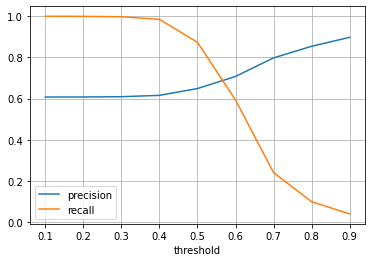

In [48]:
# Plotting the Precision-Recall curve to find the optimum threshold
plt.figure(figsize=(8,8))
result_df.plot(x='threshold', y=['precision', 'recall'])
plt.grid()
plt.show()

#### Updated model, if any
Repeat the steps 

In [49]:
# Building the model
lr = LogisticRegression(featuresCol = 'features', labelCol='is_purchased', threshold=0.55)

In [50]:
# Fitting the model on transformed df
model= lr.fit(train)

In [51]:
train_eval = model.evaluate(train)

test_eval = model.evaluate(test)

print('Train Data Recall =', train_eval.recallByLabel[1])
print('Training Precision =', train_eval.precisionByLabel[1])
print('Train Data AUC = ', train_eval.areaUnderROC)



print('Testing Data Recall =', test_eval.recallByLabel[1])
print('Testing Precision =', test_eval.precisionByLabel[1])
print('Testing Data AUC = ', test_eval.areaUnderROC)


Train Data Recall = 0.7557608967175207
Training Precision = 0.6760074288783295
Train Data AUC =  0.6550931869632257
Testing Data Recall = 0.754834862385321
Testing Precision = 0.6749770295990024
Testing Data AUC =  0.652213107468355


In [52]:
train_recall = train_eval.recallByLabel[1]
train_precision= train_eval.precisionByLabel[1]
train_f1 = 2 * (train_recall * train_precision)/(train_recall + train_precision)


test_recall = test_eval.recallByLabel[1]
test_precision= test_eval.precisionByLabel[1]
test_f1 = 2 * (test_recall * test_precision)/(test_recall + test_precision)

print('F1 Score =', train_f1)
print('F1 Score =', test_f1)

F1 Score = 0.7136629180900113
F1 Score = 0.7126758367403506


In [53]:
print('Confusion Matrix on Training Data:')
get_confusion_matrix(train_eval)

Confusion Matrix on Training Data:


,True,False
True,329774,106573
False,158052,124526


In [54]:
print('Confusion Matrix on Testing Data:')
get_confusion_matrix(test_eval)

Confusion Matrix on Testing Data:


,True,False
True,82277,26723
False,39619,30897


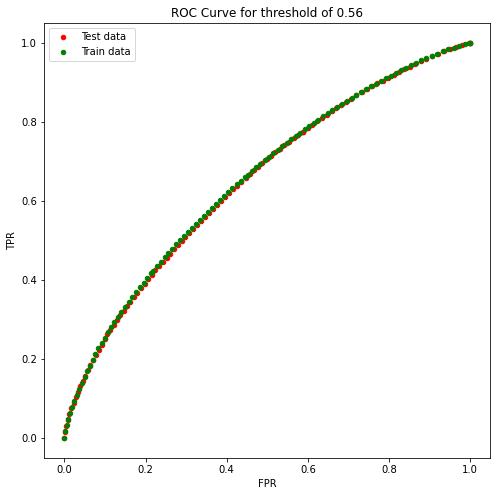

In [55]:
threshold = 0.56
test_roc = test_eval.roc.toPandas()
train_roc = train_eval.roc.toPandas()

fig, ax = plt.subplots(1,1, figsize=(8,8))
test_roc.plot( x='FPR', y='TPR', kind='scatter', label='Test data', ax=ax, c= 'r')
train_roc.plot( x='FPR', y='TPR', kind='scatter', label='Train data', ax=ax, c= 'g')
plt.legend()
plt.title('ROC Curve for threshold of {:.2f}'.format(threshold))
plt.show()


In [56]:
model.coefficients

DenseVector([-0.0392, -0.1863, -0.3867, -0.1155, -0.7266, -0.4055, -0.4873, -0.6487, -0.4192, -9.8617, -1.3471, -0.5227, -0.0244, 0.1591, -0.1863, -0.4109, -0.4452, -0.3658, -0.3715, -0.2306, -0.1988, -0.2317, -0.4055, -0.1977, -0.4361, -0.1977, -0.0684, -0.4406, -0.4598, -0.0156, -0.6789, -0.4054, -0.2523, -0.5524, -0.6424, -0.5103, 8.7133, -0.8682, -0.341, -0.3576, -0.0186, 0.214, -1.016, 0.5097, -0.5227, -0.9213, 0.1249, -0.9512, 0.7044, -0.5171, -0.214, 0.51, 0.5316, 0.6043, 0.1863, 0.0805, 0.4096, 0.5865, 0.385, 0.2899, 0.4394, 0.2756, 0.2895, 0.298, 0.3559, 0.3964, 0.2998, 0.1137, 0.0795, 0.4168, 0.3445, -0.1863, 0.0, 0.0775, 0.2972, 0.0, 0.028, 0.0649, 0.0376, 0.1296, 0.1052, -0.0037, 0.163, 0.2143, 0.0195, -0.0003, -0.0123, 0.0243, 0.0709, -0.0031, -0.0016])

In [57]:
model.save('log_reg_model')

In [58]:
#pipeline_model.save('pipeline_model')